# DTSA 5510 Final Project

## Imports

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from itertools import permutations

# old imports
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score


# latest imports
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer

from langdetect import detect

## Data import

In [2]:
# data import
reviews = pd.read_csv('data/reviews.csv')

In [3]:
# here is an initial view of a sample of rows in the dataset
reviews.sample(5)

,ID,REVIEW_DATE,IS_VERIFIED,RATING,REVIEW_TITLE,REVIEW_TEXT,NAME
6568,9484498,2020-05-12,True,5,LOVE IT!,This works so well in my flower bed the colors...,United States
695,3744499,2022-09-14,True,5,It works! Results of my latest Bone Density p...,I pinned all my hopes on this Bone Up for my o...,United States
7589,7009843,2018-09-21,False,5,Taste Legit; Probiotic A Big Plus,"First off, I can't comment on the efficacy of ...",United States
4092,5706415,2021-02-24,True,5,2 pills help get through a night shift,I work overnight sometimes I dont want to drin...,United States
1720,78671,2018-03-07,True,1,Not a Believer,No notable change. I want to believe that supp...,United States


In [4]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ID            10000 non-null  int64 
 1   REVIEW_DATE   10000 non-null  object
 2   IS_VERIFIED   10000 non-null  bool  
 3   RATING        10000 non-null  int64 
 4   REVIEW_TITLE  9999 non-null   object
 5   REVIEW_TEXT   10000 non-null  object
 6   NAME          10000 non-null  object
dtypes: bool(1), int64(2), object(4)
memory usage: 478.6+ KB


### Changing NAME field to Country

In [5]:
reviews.rename(columns={'NAME': 'COUNTRY'}, inplace = True)

### Dropping the only row with a null value

In [6]:
#
reviews[reviews['REVIEW_TITLE'].isnull()]

,ID,REVIEW_DATE,IS_VERIFIED,RATING,REVIEW_TITLE,REVIEW_TEXT,COUNTRY
2517,3566087,2018-08-09,True,5,NaN,Excellent product that is really helping my dog,United States


In [7]:
reviews.dropna(subset = ['REVIEW_TITLE'], axis = 0, inplace = True)

In [8]:
reviews.isnull().sum()

ID              0
REVIEW_DATE     0
IS_VERIFIED     0
RATING          0
REVIEW_TITLE    0
REVIEW_TEXT     0
COUNTRY         0
dtype: int64

In [9]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9999 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ID            9999 non-null   int64 
 1   REVIEW_DATE   9999 non-null   object
 2   IS_VERIFIED   9999 non-null   bool  
 3   RATING        9999 non-null   int64 
 4   REVIEW_TITLE  9999 non-null   object
 5   REVIEW_TEXT   9999 non-null   object
 6   COUNTRY       9999 non-null   object
dtypes: bool(1), int64(2), object(4)
memory usage: 556.6+ KB


### Converting REVIEW_DATE field to pandas datetime

In [10]:
reviews.head()

,ID,REVIEW_DATE,IS_VERIFIED,RATING,REVIEW_TITLE,REVIEW_TEXT,COUNTRY
0,3129911,2022-08-17,True,1,This has NO flavor,"This item has no flavor, several people have t...",United States
1,2702184,2022-06-07,True,1,Different formula,I have used this brand of sunscreen for about ...,United States
2,760128,2014-06-03,True,5,Vitex!!!,Have been using these for at least 20 months a...,United States
3,760140,2013-11-24,True,5,Stopping hair loss,Bought this to help fight hair loss along with...,United States
4,760132,2014-04-10,True,5,coming off of birth control,this company is one of the best most honest i'...,United States


In [11]:
reviews['REVIEW_DATE'] = pd.to_datetime(reviews['REVIEW_DATE'])

### Converting ID field to type object

In [12]:
reviews['ID'] = reviews['ID'].astype(object)

In [13]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9999 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   ID            9999 non-null   object        
 1   REVIEW_DATE   9999 non-null   datetime64[ns]
 2   IS_VERIFIED   9999 non-null   bool          
 3   RATING        9999 non-null   int64         
 4   REVIEW_TITLE  9999 non-null   object        
 5   REVIEW_TEXT   9999 non-null   object        
 6   COUNTRY       9999 non-null   object        
dtypes: bool(1), datetime64[ns](1), int64(1), object(4)
memory usage: 556.6+ KB


In [14]:
reviews.describe()

,REVIEW_DATE,RATING
count,9999,9999.000000
mean,2019-05-12 18:08:27.650765056,3.708071
min,2000-06-17 00:00:00,1.000000
25%,2016-11-07 00:00:00,2.000000
50%,2020-01-06 00:00:00,5.000000
75%,2022-08-11 00:00:00,5.000000
max,2024-06-17 00:00:00,5.000000
std,NaN,1.625120


## Visualizations

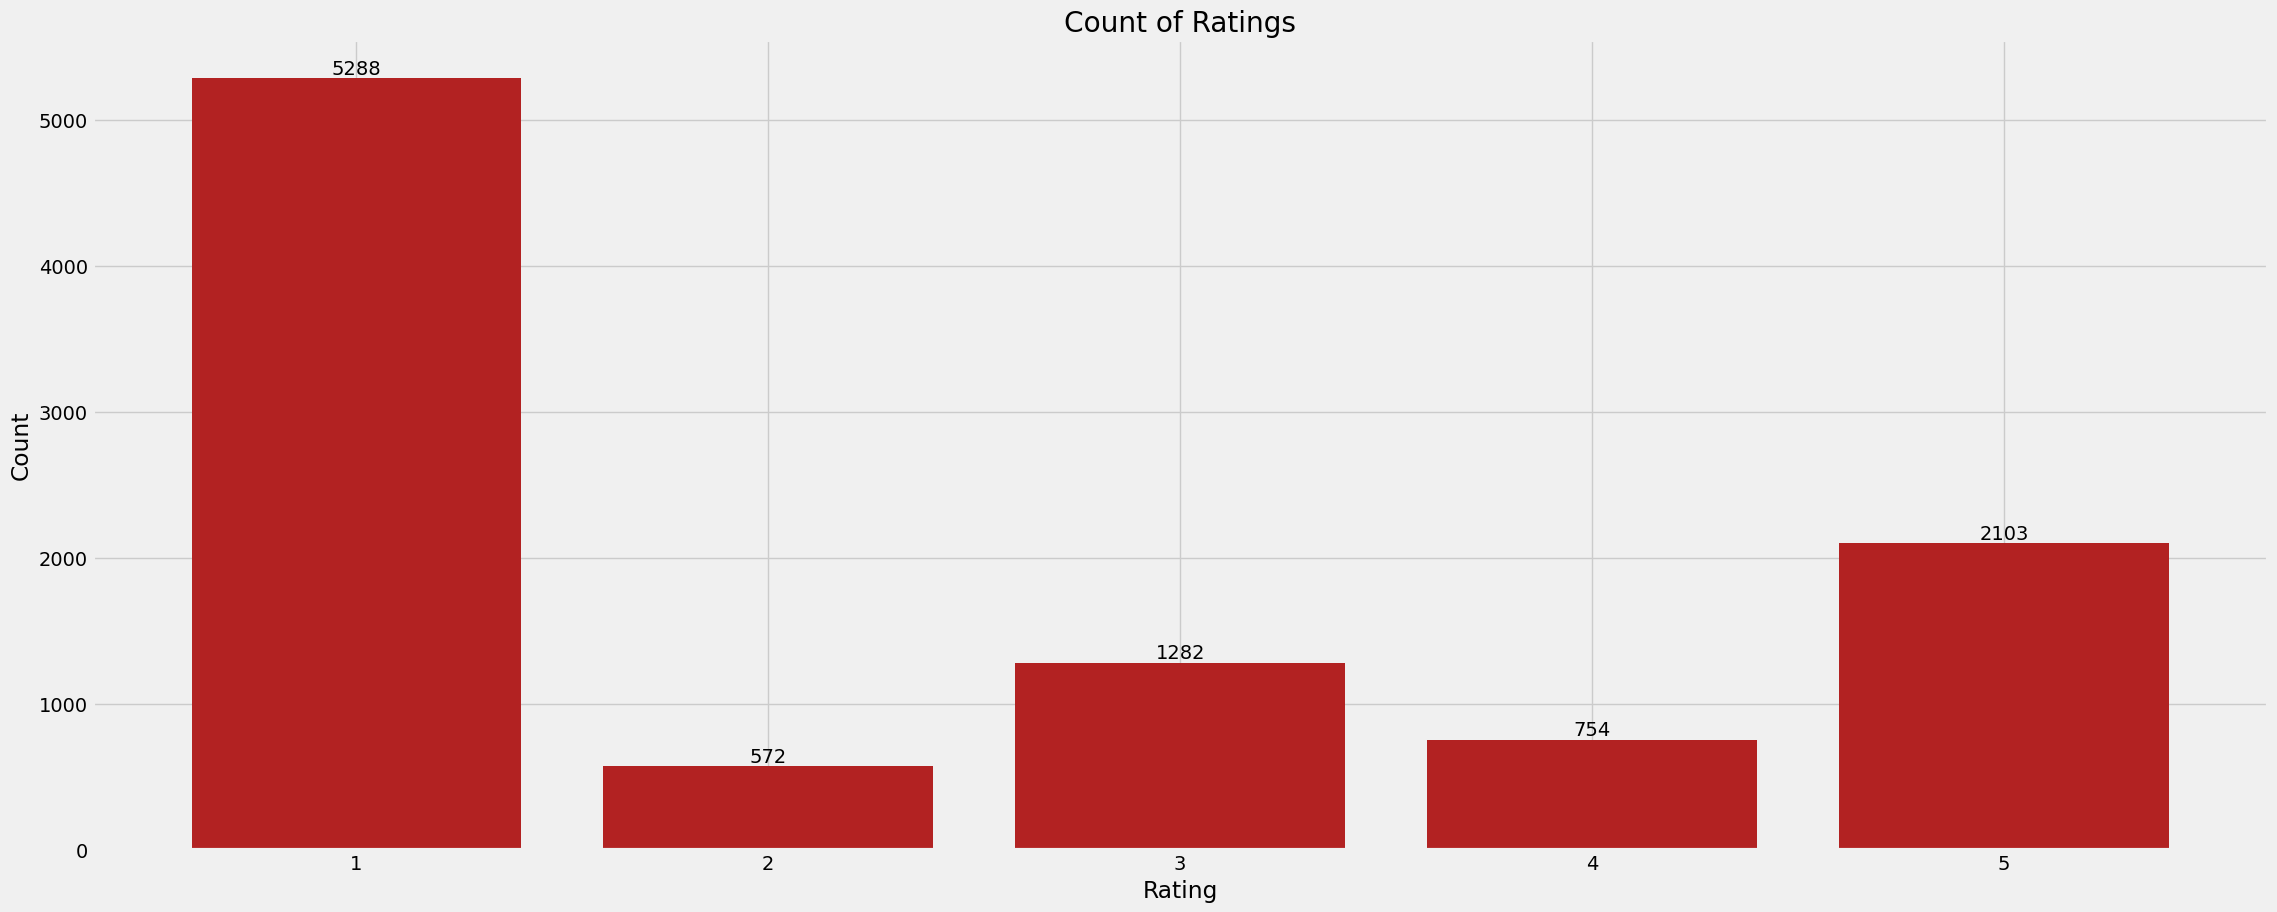

In [15]:
plt.style.use('fivethirtyeight')
fix, ax = plt.subplots(figsize = (25, 10))

ratings = reviews['RATING'].value_counts()
ind = reviews['RATING'].unique()

plt.bar(ind, ratings, color = 'firebrick', align = 'center')

for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2,
            p.get_height(),
            '{:.0f}'.format(p.get_height()),
            ha='center',
            va='bottom'
           )

plt.title('Count of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

In [16]:
# dataset is unbalanced, but that is ok in our context as we will not be exploring the relationship between variables, just the underlying text

In [17]:
reviews.head()

,ID,REVIEW_DATE,IS_VERIFIED,RATING,REVIEW_TITLE,REVIEW_TEXT,COUNTRY
0,3129911,2022-08-17,True,1,This has NO flavor,"This item has no flavor, several people have t...",United States
1,2702184,2022-06-07,True,1,Different formula,I have used this brand of sunscreen for about ...,United States
2,760128,2014-06-03,True,5,Vitex!!!,Have been using these for at least 20 months a...,United States
3,760140,2013-11-24,True,5,Stopping hair loss,Bought this to help fight hair loss along with...,United States
4,760132,2014-04-10,True,5,coming off of birth control,this company is one of the best most honest i'...,United States


## Removing non-english reviews

In [18]:
def detect_language(text):
    try:
        lang = detect(text)
    except:
        lang = 'unknown'
    return lang

In [19]:
reviews['language'] = reviews['REVIEW_TEXT'].apply(detect_language)

In [20]:
reviews['language'].value_counts()

language
en         9599
es          104
de           75
ja           63
fr           59
it           34
pt           11
ca            8
af            8
ro            6
nl            5
so            5
no            5
da            3
id            2
sv            2
sl            2
et            2
tl            2
cy            2
unknown       1
hu            1
Name: count, dtype: int64

In [21]:
english_mask = reviews['language'] == 'en'
english_reviews = reviews[english_mask]

In [22]:
english_reviews['word_count'] = english_reviews['REVIEW_TEXT'].apply(lambda x: len(x.split()))

/var/folders/lr/994tkpld58q9sbf0jsds90h80000gn/T/ipykernel_311/1936066079.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_reviews['word_count'] = english_reviews['REVIEW_TEXT'].apply(lambda x: len(x.split()))


Text(0.5, 1.0, 'Number of words by review histogram')

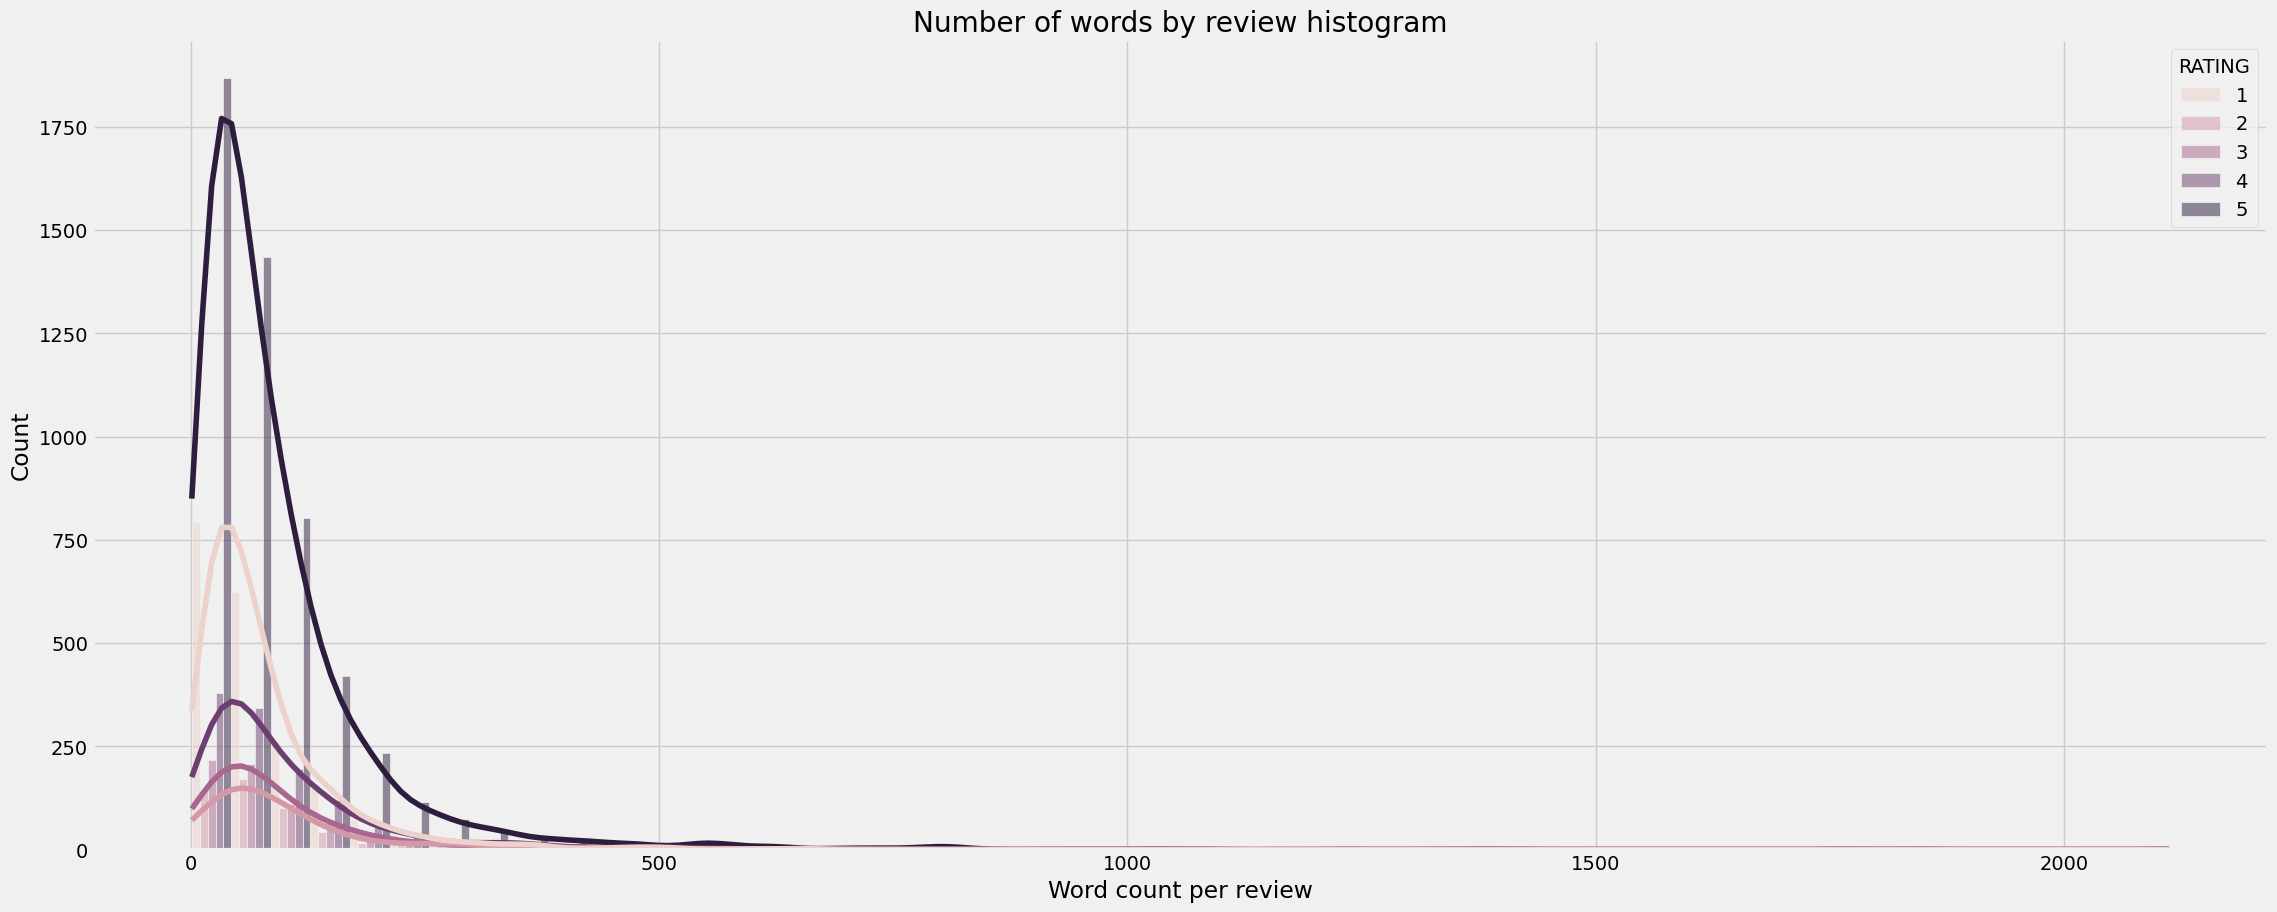

In [23]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize = (25, 10))

sns.histplot(data=english_reviews, x='word_count', hue='RATING', multiple='dodge', legend='RATING', kde = True, bins = 50)

plt.xlabel('Word count per review')
plt.ylabel('Count')
plt.title('Number of words by review histogram')

/var/folders/lr/994tkpld58q9sbf0jsds90h80000gn/T/ipykernel_311/3030392025.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(data, labels = english_reviews['RATING'].unique(), patch_artist=True)


Text(0, 0.5, 'Word count')

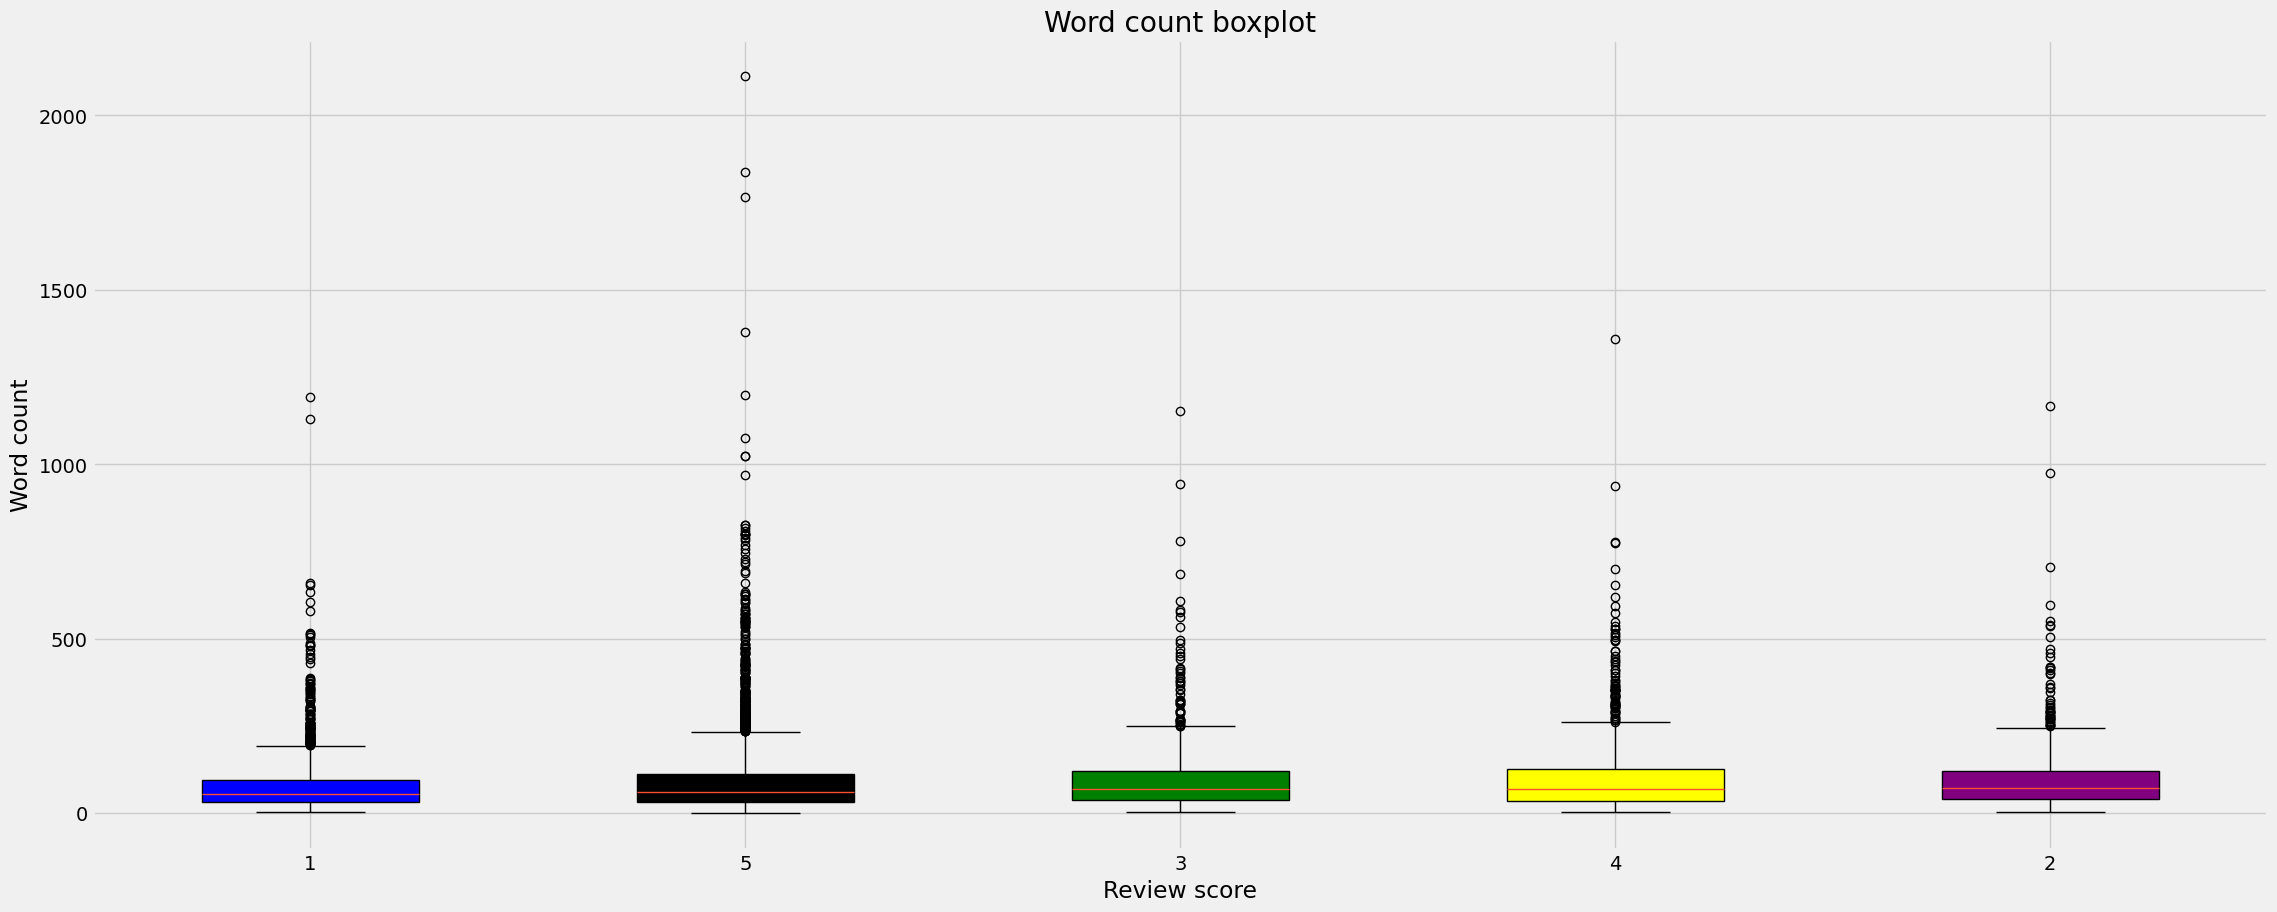

In [24]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize = (25, 10))

wc_group = english_reviews.groupby('RATING')['word_count'].apply(list)
data = [wc_group[cat] for cat in english_reviews['RATING'].unique()]

bp = plt.boxplot(data, labels = english_reviews['RATING'].unique(), patch_artist=True)

colors = ['blue', 'black', 'green', 'yellow', 'purple']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

plt.title('Word count boxplot')
plt.xlabel('Review score')
plt.ylabel('Word count')

In [54]:
pd.set_option('display.max_colwidth', None)
english_reviews_train['REVIEW_TEXT'].sample(1)

2749    Beautiful fit and finish but not durable.  Probably great if you're flipping a house.  I installed a complete line of Baldwin Madrina entry door locks and deadbolts before learning that they are no longer made by Baldwin but instead by Kwikset after being bought by Black and Decker in 2003.  While these look great really nice, the Kwikset Smartkey cylinders are failing after less than 5 years.  I have had 3 go bad so far this year.  The key simply stops working.  While they have a "lifetime" warranty, I have had to purchase replacements since mailing the failed lock in and waiting for a replacement takes > 2 weeks and, in my neighborhood, leaving the front door unlocked for 2 weeks is simply not an option.  Now I know why my local locksmith referred to them as "fake Baldwins" when I inquired about getting them repaired which I thought might be faster.  Hopefully, Kwikset/Baldwin will re-design the very convenient Smartkey cylinders to be more durable since it is going to be ver

# Count Vectorize

In [63]:
def remove_punctuation(text):
    final = "".join(u for u in text if u not in ('?', '.', ';', ':', '!', '"', "'", '(', ')', '[', ']', '/', ',', '-'))
    return final

In [45]:
token = RegexpTokenizer(f'[a-zA-Z0-9]+')

In [64]:
test_token = 'Beautiful fit and finish but not durable.  Probably great if you\'re flipping a house.  I installed a complete line of Baldwin Madrina entry door locks and deadbolts before learning that they are no longer made by Baldwin but instead by Kwikset after being bought by Black and Decker in 2003.  While these look great really nice, the Kwikset Smartkey cylinders are failing after less than 5 years.  I have had 3 go bad so far this year.  The key simply stops working.  While they have a "lifetime" warranty, I have had to purchase replacements since mailing the failed lock in and waiting for a replacement takes > 2 weeks and, in my neighborhood, leaving the front door unlocked for 2 weeks is simply not an option.  Now I know why my local locksmith referred to them as "fake Baldwins" when I inquired about getting them repaired which I thought might be faster.  Hopefully, Kwikset/Baldwin will re-design the very convenient Smartkey cylinders to be more durable since it is going to be very expensive for me to replace all the entry locks and deadbolts with another make (probably Schlage entry sets if this continues'

In [65]:
remove_punctuation(test_token)

'Beautiful fit and finish but not durable  Probably great if youre flipping a house  I installed a complete line of Baldwin Madrina entry door locks and deadbolts before learning that they are no longer made by Baldwin but instead by Kwikset after being bought by Black and Decker in 2003  While these look great really nice the Kwikset Smartkey cylinders are failing after less than 5 years  I have had 3 go bad so far this year  The key simply stops working  While they have a lifetime warranty I have had to purchase replacements since mailing the failed lock in and waiting for a replacement takes > 2 weeks and in my neighborhood leaving the front door unlocked for 2 weeks is simply not an option  Now I know why my local locksmith referred to them as fake Baldwins when I inquired about getting them repaired which I thought might be faster  Hopefully KwiksetBaldwin will redesign the very convenient Smartkey cylinders to be more durable since it is going to be very expensive for me to repla

In [66]:
token.tokenize(remove_punctuation(test_token))

['Beautiful',
 'fit',
 'and',
 'finish',
 'but',
 'not',
 'durable',
 'Probably',
 'great',
 'if',
 'youre',
 'flipping',
 'a',
 'house',
 'I',
 'installed',
 'a',
 'complete',
 'line',
 'of',
 'Baldwin',
 'Madrina',
 'entry',
 'door',
 'locks',
 'and',
 'deadbolts',
 'before',
 'learning',
 'that',
 'they',
 'are',
 'no',
 'longer',
 'made',
 'by',
 'Baldwin',
 'but',
 'instead',
 'by',
 'Kwikset',
 'after',
 'being',
 'bought',
 'by',
 'Black',
 'and',
 'Decker',
 'in',
 '2003',
 'While',
 'these',
 'look',
 'great',
 'really',
 'nice',
 'the',
 'Kwikset',
 'Smartkey',
 'cylinders',
 'are',
 'failing',
 'after',
 'less',
 'than',
 '5',
 'years',
 'I',
 'have',
 'had',
 '3',
 'go',
 'bad',
 'so',
 'far',
 'this',
 'year',
 'The',
 'key',
 'simply',
 'stops',
 'working',
 'While',
 'they',
 'have',
 'a',
 'lifetime',
 'warranty',
 'I',
 'have',
 'had',
 'to',
 'purchase',
 'replacements',
 'since',
 'mailing',
 'the',
 'failed',
 'lock',
 'in',
 'and',
 'waiting',
 'for',
 'a',
 'repla

# Train Test Split P2

# Train Test Split

In [25]:
# final sample of the english_reviews dataset that will be split into training and testing datasets
english_reviews.sample(5)

,ID,REVIEW_DATE,IS_VERIFIED,RATING,REVIEW_TITLE,REVIEW_TEXT,COUNTRY,language,word_count
218,86052,2017-08-18,True,5,LOVE this stuff,LOVE this stuff!I took collogen the last few m...,United States,en,35
7325,3656871,2022-02-09,True,2,Doesn’t really work,I bought this product last year (2021) when it...,United States,en,417
2710,6265223,2017-05-13,True,5,"best ""bare skin"" type out there",Amazing. Best condoms we have found. Seriously...,United States,en,43
5977,1150173,2010-03-10,True,5,Fantastic,"Great price, great taste, love the ""Subscribe ...",United States,en,37
9636,4066936,2023-01-04,True,4,Very strong,One spritz and the entire room fills with a ve...,United States,en,30


In [26]:
english_reviews_train, english_reviews_test = train_test_split(english_reviews, test_size=0.15, random_state=42)

In [27]:
print(f'The number of rows in the training dataset is: {len(english_reviews_train)}')

The number of rows in the training dataset is: 8159


In [28]:
print(f'The number of rows in the testing dataset is: {len(english_reviews_test)}')

The number of rows in the testing dataset is: 1440


In [29]:
y = english_reviews_train['RATING'].tolist()
english_reviews_train_text = english_reviews_train['REVIEW_TEXT']

# Implementing TF-IDF

In [30]:
tfidf = TfidfVectorizer(ngram_range =(1,2), stop_words = 'english', max_features = 1000)
features = tfidf.fit_transform(english_reviews_train_text)
df_tfidf = pd.DataFrame(features.toarray(), columns = tfidf.get_feature_names_out())

In [31]:
# original review
english_reviews_train.iloc[2]['REVIEW_TEXT']

"I love caron , it's so beautiful,  but it's not for beginners because if you aren't careful it will unravel as it's very fine and pretty.  One of my favorite yarns.  It also came very quickly.  I was so happy about that ."

In [32]:
df_tfidf_three  = df_tfidf.iloc[2]
sorted_doc_three_scores = df_tfidf_three.sort_values(ascending=False)

In [33]:
sorted_doc_three_scores[:20]

aren             0.376153
beautiful        0.369643
careful          0.366938
favorite         0.358819
quickly          0.317634
fine             0.287203
came             0.278496
pretty           0.277594
happy            0.272917
love             0.214473
purchased        0.000000
product works    0.000000
quick            0.000000
pro              0.000000
quality          0.000000
probably         0.000000
probiotics       0.000000
problem          0.000000
problems         0.000000
process          0.000000
Name: 2, dtype: float64

Text(0.5, 0, 'Terms')

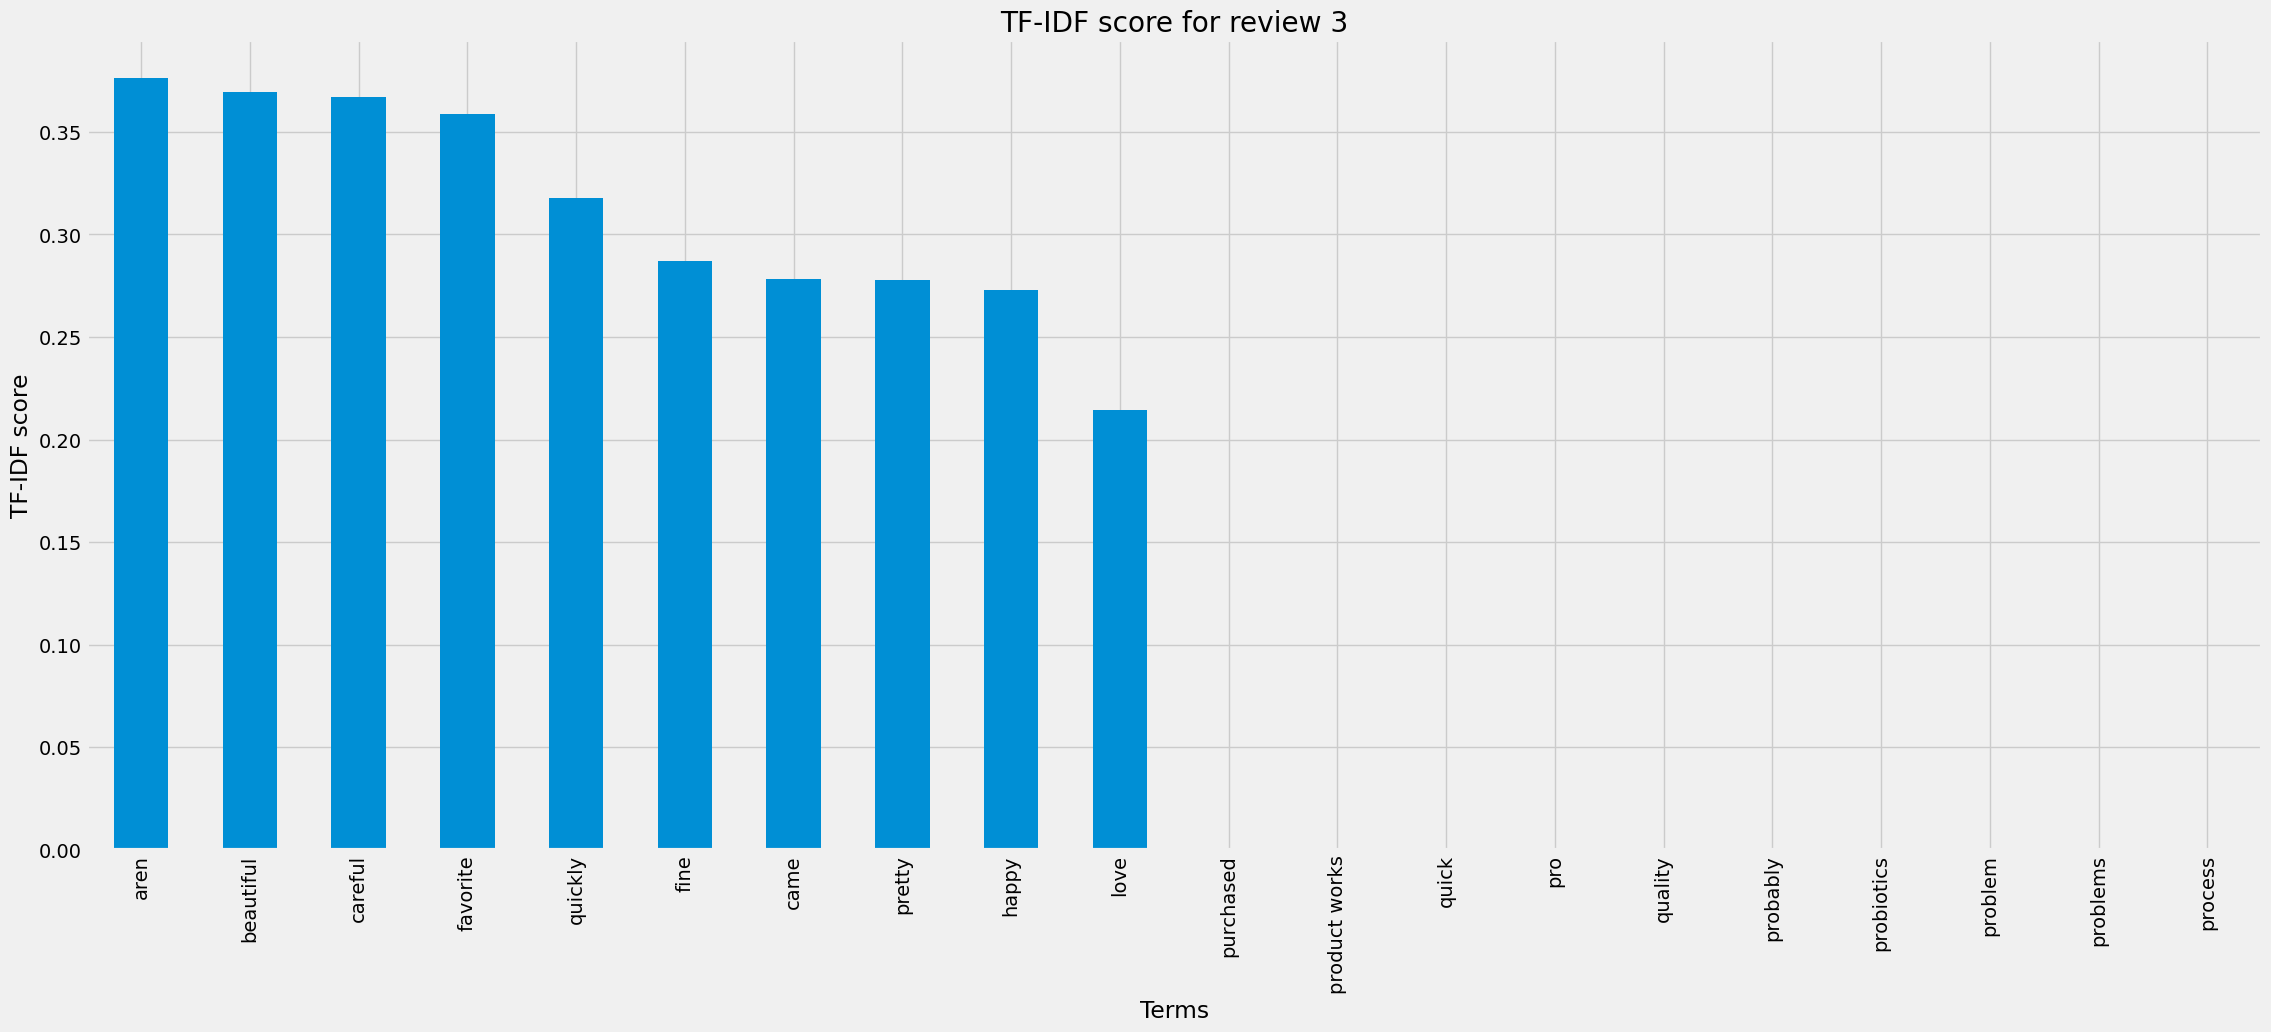

In [34]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize = (25, 10))

sorted_doc_three_scores[:20].plot(kind = 'bar')
plt.title('TF-IDF score for review 3')
plt.ylabel('TF-IDF score')
plt.xlabel('Terms')

# Unsupervised model

In [35]:
model_nmf = NMF( init = 'random', beta_loss = 'frobenius',  verbose = 1, random_state = 42).fit(df_tfidf)
# max_iter = 100,
# n_components = 5,

/Users/cman/Desktop/code/customer_reviews/.venv/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1200: FutureWarning: The default value of `n_components` will change from `None` to `'auto'` in 1.6. Set the value of `n_components` to `None` explicitly to suppress the warning.
  warnings.warn(


violation: 1.0
violation: 0.37071940585730134
violation: 0.18653409569828172
violation: 0.11751178629870276
violation: 0.07368820198843652
violation: 0.044319022149273496
violation: 0.02744696400666932
violation: 0.01893889605901507
violation: 0.014305851597060782
violation: 0.011802504253696057
violation: 0.009958419230759696
violation: 0.007956722054521949
violation: 0.00640507673529815
violation: 0.005198639527460903
violation: 0.003909172945831757
violation: 0.0030624256480322283
violation: 0.002321224604282337
violation: 0.0019806962265342012
violation: 0.0018771151770670487
violation: 0.0018715430292708271
violation: 0.0018856842426377858
violation: 0.001701715515717006
violation: 0.0015835259678161546
violation: 0.0014992425051322232
violation: 0.0012209165561808638
violation: 0.0009613810046532925
violation: 0.0010437907198441072
violation: 0.0010033647949247637
violation: 0.001074115888528422
violation: 0.0008285146661400814
violation: 0.0005439953631019925
violation: 0.000611

In [36]:
weights = model_nmf.transform(df_tfidf)
pd.DataFrame(weights).head()

/Users/cman/Desktop/code/customer_reviews/.venv/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1200: FutureWarning: The default value of `n_components` will change from `None` to `'auto'` in 1.6. Set the value of `n_components` to `None` explicitly to suppress the warning.
  warnings.warn(


violation: 1.0
violation: 0.02930056374618934
violation: 0.00550006262878493
violation: 0.0015969224228727372
violation: 0.0006090274725418436
violation: 0.00029439422105068797
violation: 0.0001824225372382942
violation: 0.00013803689540558013
violation: 0.00011749393729029404
violation: 0.00010322818083527812
violation: 9.114961852245858e-05
Converged at iteration 12


,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.0,0.0,3.28894,0.000000,0.0,5.973811,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000665,0.000746,0.0,0.0,0.0
1,0.0,0.0,0.00000,2.327156,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
2,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
3,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
4,0.0,0.0,0.00000,1.842709,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0


In [37]:
pred = np.argmax(weights, axis = 1)
pred

array([ 5,  3, 18, ..., 21, 14,  3])

In [38]:
# predictions are zero indexed, need to add one to match the y values
pred_adjusted = pred + 1

In [39]:
def label_compare(y, yp):
    '''Function that for all permutations of labels, retruns the best accuracy score and order'''
    global best_ordering
    unique_labels = np.unique(yp)
    best_accuracy = 0.0

    for order in permutations(unique_labels):
        label_map = {unique_labels[i]: order[i] for i in range(len(unique_labels))}
        reordered_yp = np.vectorize(label_map.get)(yp)

        current_score = accuracy_score(y, reordered_yp)
        if current_score > best_accuracy:
            best_accuracy = current_score
            best_ordering = order
        
    return best_accuracy

In [40]:
print(f'The best accuracy achieved with random hyperparameters for the NMF model is: {label_compare(y, pred_adjusted)}')

KeyboardInterrupt: 

In [ ]:
pred[:10]

In [ ]:
y[:10]

In [ ]:
labels = np.unique(pred_adjusted)
label_map = dict(zip(labels, best_ordering))
reorder_yp = np.array([label_map[lbl] for lbl in pred_adjusted])

In [ ]:
labels

In [ ]:
best_ordering

In [ ]:
reorder_yp

In [ ]:
label_names = english_reviews_train['RATING'].unique().tolist()
l = pd.Index(label_names)
cm = pd.crosstab(y, reorder_yp)
# cm = pd.crosstab(l[y], l[reorder_yp])

plt.figure(figsize=(10, 4))
sns.heatmap(cm, annot=True, square=True, cmap='Reds', fmt='.0f', cbar=False)
plt.title('NMF random model confusion matrix', fontsize = 12)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.xticks(rotation=20, fontsize=8)
plt.yticks(fontsize=8)

In [ ]:
def custom_scoring(estimator, X, y):
    'Creating a scoring function to be used in our GridSearchCV'
    W = estimator.transform(X)
    predictions = np.argmax(W, axis=1)
    return label_compare(y, predictions)

In [ ]:
pipe = Pipeline([
    ('tfidfvectorizer', TfidfVectorizer(ngram_range =(1,2), stop_words = 'english', max_features = 1000)),
    ( 'nmf', NMF(n_components = 5, init = 'random', beta_loss = 'frobenius'))
])

params = [{
    # 'tfidfvectorizer__ngram_range': [(1, 2)],
    'tfidfvectorizer__min_df': [1, 2, 3],
    'nmf__alpha_W': [0, .01, .02],
    'nmf__alpha_H': [0, .01, .02]
}]

In [ ]:
grid = GridSearchCV(pipe, param_grid = params, scoring = custom_scoring, cv = 10)
x = english_reviews_train['REVIEW_TEXT']
y = english_reviews_train['RATING']
grid.fit(x, y)

In [ ]:
cv_results = pd.DataFrame(grid.cv_results_).sort_values(by='mean_test_score')
pd.set_option('display.max_colwidth', None)
cv_results[['mean_fit_time', 'params', 'mean_test_score', 'rank_test_score']].sort_values(by='rank_test_score').iloc[:10]